In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from datasets import load_dataset
import numpy as np
from collections import Counter
import spacy
import matplotlib.pyplot as plt

import nltk 
from nltk.tokenize import word_tokenize

# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# # Load spaCy's English tokenizer
# nlp = spacy.load("en_core_web_sm")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vocabulary Size: 18031
Number of OOV words: 1865


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/var/folders/d9/99zh55td5557wrk09bgvss_w0000gn/T/ipykernel_1863/1879008259.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentences_padded = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True, padding_value=0)


Epoch [1/50], Train Loss: 161.4130, Train Accuracy: 0.6868, Validation Loss: 0.4973, Validation Accuracy: 0.7749
Epoch [2/50], Train Loss: 126.7830, Train Accuracy: 0.7719, Validation Loss: 0.4773, Validation Accuracy: 0.7777
Epoch [3/50], Train Loss: 112.5279, Train Accuracy: 0.8076, Validation Loss: 0.4888, Validation Accuracy: 0.7655
Epoch [4/50], Train Loss: 101.5421, Train Accuracy: 0.8275, Validation Loss: 0.4736, Validation Accuracy: 0.7805
Epoch [5/50], Train Loss: 93.3177, Train Accuracy: 0.8463, Validation Loss: 0.4804, Validation Accuracy: 0.7814
Epoch [6/50], Train Loss: 82.6052, Train Accuracy: 0.8683, Validation Loss: 0.4613, Validation Accuracy: 0.7899
Epoch [7/50], Train Loss: 74.3676, Train Accuracy: 0.8789, Validation Loss: 0.5130, Validation Accuracy: 0.7683
Epoch [8/50], Train Loss: 70.5189, Train Accuracy: 0.8902, Validation Loss: 0.5290, Validation Accuracy: 0.7683
Epoch [9/50], Train Loss: 65.3553, Train Accuracy: 0.8987, Validation Loss: 0.5082, Validation Accur

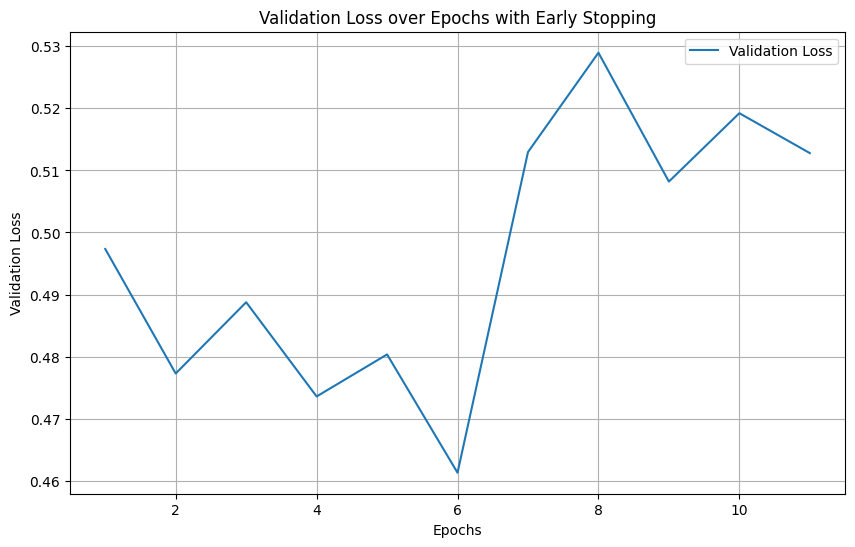

In [8]:
def tokenize(text):
    return word_tokenize(text.lower())

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embedding_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict

glove_embeddings = load_glove_embeddings("glove.6B/glove.6B.300d.txt")

# Build vocabulary from the training data
word_counter = Counter()
for sample in train_dataset:
    word_counter.update(tokenize(sample['text']))

# Create word-to-index mapping, with index 0 for padding and index 1 for UNK
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counter.items())}  # idx+2 to reserve 0 for padding, 1 for UNK
vocab_size = len(vocab) + 2  # +2 for padding index 0 and UNK index 1

# Initialize embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Row 0 is for padding, row 1 is for UNK

# Compute the mean and standard deviation of known word embeddings
known_embeddings = np.array(list(glove_embeddings.values()))
embedding_mean = np.mean(known_embeddings, axis=0)
embedding_std = np.std(known_embeddings, axis=0)

oov_words = []

# Fill the embedding matrix
for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        oov_words.append(word)
        # Sample from normal distribution with same mean and std as known embeddings
        embedding_matrix[idx] = np.random.normal(embedding_mean, embedding_std, embedding_dim)

print(f"Vocabulary Size: {vocab_size}")
print(f"Number of OOV words: {len(oov_words)}")

# Define the Sentiment Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.sentences = [tokenize_sentence(sample['text'], vocab) for sample in dataset]
        self.labels = [sample['label'] for sample in dataset]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.labels[idx])

# Tokenizing the dataset and ensuring valid index range
def tokenize_sentence(sentence, vocab):
    tokens = tokenize(sentence)
    return [vocab.get(token, 1) for token in tokens]  # Replace OOV words with index 1 (UNK)

# Creating datasets and dataloaders
batch_size = 32

train_data = SentimentDataset(train_dataset, vocab)
val_data = SentimentDataset(validation_dataset, vocab)
test_data = SentimentDataset(test_dataset, vocab)

# Padding function for data loader
def collate_fn(batch):
    sentences, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences])
    sentences_padded = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return sentences_padded, labels, lengths

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# AVERAGE POOLING
# class RNNModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
#         super(RNNModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
#         self.embedding.weight.requires_grad = False  # Freeze embeddings

#         self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
#         self.dropout = nn.Dropout(0.5)  # Dropout layer to reduce overfitting (can be increased)
#         self.batch_norm = nn.BatchNorm1d(hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, lengths):
#         embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
#         packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
#         packed_rnn_out, _ = self.rnn(packed_embedded)
#         rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

#         # Apply average pooling across the sequence length dimension
#         batch_size, max_len, hidden_dim = rnn_out.size()
#         mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
#         rnn_out = rnn_out * mask.unsqueeze(2)  # Mask out padding tokens
#         sentence_representation = rnn_out.sum(dim=1) / lengths.unsqueeze(1).float()

#         sentence_representation = self.batch_norm(sentence_representation)
#         sentence_representation = self.dropout(sentence_representation)
#         output = self.fc(sentence_representation)
#         return output

# MAX POOLING
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.6)  # Dropout layer to reduce overfitting
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # Pack the sequences to handle varying sentence lengths
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_rnn_out, _ = self.rnn(packed_embedded)
        rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

        # Apply max pooling across the sequence length dimension
        batch_size, max_len, hidden_dim = rnn_out.size()
        
        # Apply mask to ignore padding tokens in the max pooling operation
        mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
        rnn_out[~mask] = float('-inf')  # Set padding positions to negative infinity before max pooling
        
        # Max pooling across the time dimension
        sentence_representation, _ = torch.max(rnn_out, dim=1)  # Max pooling along the time axis
        
        # Apply batch normalization and dropout
        sentence_representation = self.batch_norm(sentence_representation)
        sentence_representation = self.dropout(sentence_representation)

        # Pass through fully connected layer for classification
        output = self.fc(sentence_representation)
        return output

# Model parameters
hidden_dim = 256
output_dim = 2  # Sentiment (positive or negative)

# Initialize the model
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)

# Training parameters
epochs = 50
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Keep weight decay
criterion = nn.CrossEntropyLoss()

# Initialize the learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Initialize the best validation loss and other parameters for early stopping
best_val_loss = float('inf')
patience = 5  # Stop training if validation loss does not improve for 5 consecutive epochs
epochs_no_improve = 0
early_stop = False  # Flag to control early stopping

# List to store validation losses for plotting
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for sentences, labels, lengths in train_loader:
        optimizer.zero_grad()
        output = model(sentences, lengths)
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for sentences, labels, lengths in val_loader:
            output = model(sentences, lengths)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val

    # Store validation loss for plotting
    val_losses.append(val_loss)

    # Scheduler step: Reduces learning rate when validation loss plateaus for 3 epochs
    scheduler.step(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset the patience counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        early_stop = True
        break

    # Output training and validation results
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if early_stop:
        break

# Plot validation losses
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs with Early Stopping')
plt.legend()
plt.grid(True)
plt.show()
